In [1]:
import warnings
warnings.filterwarnings(action='ignore')

In [2]:
import sqlite3
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
_4dm4_data_fp = 'dataset/4dm4.db'
soft5_data_fp = 'dataset/soft5.db'
soft6_data_fp = 'dataset/soft6.db'

_4dm4_data = sqlite3.connect(_4dm4_data_fp)
soft5_data = sqlite3.connect(soft5_data_fp)
soft6_data = sqlite3.connect(soft6_data_fp)

In [4]:
_4dm4_sql = """SELECT * FROM scores WHERE beatmap_type != \"SV\""""
soft_sql = """SELECT players.name as player_name, scores.beatmap_id, mappools.round, mappools.beatmap_type, scores.score
FROM scores LEFT JOIN mappools ON (scores.beatmap_id = mappools.beatmap_id)
INNER JOIN players ON (scores.player_id = players.id)"""

_4dm4_dataset = pd.read_sql(_4dm4_sql, _4dm4_data)
soft5_dataset = pd.read_sql(soft_sql, soft5_data)
soft6_dataset = pd.read_sql(soft_sql, soft6_data)

In [5]:
_4dm4_dataset

,player_name,round,beatmap_type,beatmap_tag,score,score_logit
0,drag_,Q,RC,1,980590,3.922366
1,JPBenedictGame,Q,RC,1,991778,4.792686
2,iVALORUS,Q,RC,1,950399,2.952871
3,BL5,Q,RC,1,994054,5.119073
4,-Tebo-,Q,RC,1,994631,5.221730
...,...,...,...,...,...,...
2760,MisteurFR,GF,TB,1,932066,2.618867
2761,Gray Hardrock,GF,TB,1,908730,2.298226
2762,--Pavin--,GF,TB,1,919303,2.432914
2763,shokoha,GF,TB,1,910134,2.315272


In [6]:
soft6_dataset

,player_name,beatmap_id,round,beatmap_type,score
0,[KN]Lordieee,2121101,PO,HB,980915
1,[KN]Lordieee,2388838,PO,HB,983744
2,[KN]Lordieee,3202329,PO,RC,987171
3,[KN]Lordieee,3392120,PO,RC,957210
4,[KN]Lordieee,3501159,PO,LN,981079
...,...,...,...,...,...
1465,Lothus,3588596,F,HB,985477
1466,Lothus,3589150,F,RC,970469
1467,Lothus,3589487,F,HB,956582
1468,Lothus,3590133,F,RC,984770


In [7]:
def logit(x):
    return np.log(x / (1e6 - x))

In [8]:
soft6_dataset['score_logit'] = soft6_dataset['score'].apply(logit)
soft5_dataset['score_logit'] = soft5_dataset['score'].apply(logit)

In [9]:
soft5_dataset = soft5_dataset.rename({'beatmap_id': 'beatmap_tag'}, axis=1)
soft6_dataset = soft6_dataset.rename({'beatmap_id': 'beatmap_tag'}, axis=1)

In [10]:
from utils.etimodel import ETIModel, GeneralizedETIModel

In [11]:
_4dm4_players = _4dm4_dataset['player_name'].unique().astype(str)
soft5_players = soft5_dataset['player_name'].unique().astype(str)
soft6_players = soft6_dataset['player_name'].unique().astype(str)

In [12]:
np.intersect1d(_4dm4_players, soft5_players)

array(['ERA medium kek', 'Miaurichesu', 'Mr_adamello', 'NightNarumi',
       'Zergh', '_Seth', 'samuelhklumpers', 'shokoha', 'soutin',
       'spamblock', 'wolfpup08'], dtype='<U15')

In [13]:
np.intersect1d(_4dm4_players, soft6_players)

array(['Akatsumi Chan', 'Doryoku', 'ERA medium kek', 'Enthalpy',
       'Froggie09', 'Mateo12345', 'Mr_adamello', 'Nikita3006', 'Satsukel',
       'ShiroPeDeFresa', 'TheFunk', 'Tiger', 'Zergh', 'shokoha',
       'wolfpup08'], dtype='<U15')

In [14]:
from utils.tables import get_table_from_records

eti_4dm4 = ETIModel()

def get_beatmap_category_table(records: pd.DataFrame, category: str):
    return get_table_from_records(records[records['beatmap_type'] == category], 'player_name', 'beatmap', 'score_logit')

_4dm4_dataset['beatmap'] = _4dm4_dataset['round'] + "_" + _4dm4_dataset['beatmap_type'] + "_" + _4dm4_dataset['beatmap_tag'].astype(str)
rc = get_beatmap_category_table(_4dm4_dataset, "RC")
hb = get_beatmap_category_table(_4dm4_dataset, "HB")
ln = get_beatmap_category_table(_4dm4_dataset, "LN")

rc_eti = pd.DataFrame(eti_4dm4.fit(rc.values), index=rc.index)
hb_eti = pd.DataFrame(eti_4dm4.fit(hb.values), index=hb.index)
ln_eti = pd.DataFrame(eti_4dm4.fit(ln.values), index=ln.index)

eti_cats = pd.DataFrame(index=_4dm4_players)
eti_cats['rc'] = rc_eti
eti_cats['hb'] = hb_eti
eti_cats['ln'] = ln_eti
eti_cats['rc'] = eti_cats['rc'].fillna(eti_cats['rc'].min())
eti_cats['hb'] = eti_cats['hb'].fillna(eti_cats['hb'].min())
eti_cats['ln'] = eti_cats['ln'].fillna(eti_cats['ln'].min())

In [15]:
eti_cats

,rc,hb,ln
drag_,-2.203943,-1.922962,-1.848750
JPBenedictGame,-2.034906,-1.485538,-1.881729
iVALORUS,-2.368395,-1.628269,-2.113531
BL5,-1.515542,-1.421774,-1.379444
-Tebo-,1.049462,0.151761,-1.019061
...,...,...,...
oliverq,-1.845866,-1.815909,-2.073226
TheFunk,-2.227620,-1.522535,-2.290171
Herarudo,-2.308657,-1.922962,-2.120954
[Antonio],-2.664934,-1.588431,-2.290171


In [16]:
soft6_model = GeneralizedETIModel(_4dm4_dataset, ['RC', 'HB', 'LN'])

In [17]:
soft6_model.fit_regression(soft6_dataset)

In [18]:
soft6_model.predict(soft6_dataset).sort_values(0, ascending=False).head(15)

,0
[GS]Myuka,25.975869
Amerom,20.429936
Reyi,18.339128
SillyFangirl,18.014781
-Aishiteru-,16.792270
Silhoueska Elze,16.465279
XxNewson1234xX,14.947089
Lothus,12.895434
Lott,11.348112
MegMewtwoZ,9.657195


In [19]:
soft5_model = GeneralizedETIModel(_4dm4_dataset, ['RC', 'HB', 'LN'])
soft5_model.fit_regression(soft5_dataset)

In [20]:
soft5_model.predict(soft5_dataset).sort_values(0, ascending=False).tail(15)

,0
AMDuskia1996,1.723566
AdamAckerville,1.723124
jkzu123,1.718962
Pope Gadget,1.715159
Yonk_,1.714188
Alter-,1.709511
LeMarcinho,1.703783
mashu,1.696689
BaniiYanii,1.696479
BossPlays,1.695126


In [21]:
soft6_etis = soft6_model.predict(soft6_dataset).sort_values(0, ascending=False)
soft6_etis.to_csv('soft6_4dm_eti.csv')

soft5_etis = soft5_model.predict(soft5_dataset).sort_values(0, ascending=False)
soft5_etis.to_csv('soft5_4dm_eti.csv')

In [22]:
eti_cats['avg'] = np.mean(eti_cats[['rc', 'hb', 'ln']].values, axis=1)

In [23]:
eti_cats

,rc,hb,ln,avg
drag_,-2.203943,-1.922962,-1.848750,-1.991885
JPBenedictGame,-2.034906,-1.485538,-1.881729,-1.800725
iVALORUS,-2.368395,-1.628269,-2.113531,-2.036732
BL5,-1.515542,-1.421774,-1.379444,-1.438920
-Tebo-,1.049462,0.151761,-1.019061,0.060721
...,...,...,...,...
oliverq,-1.845866,-1.815909,-2.073226,-1.911667
TheFunk,-2.227620,-1.522535,-2.290171,-2.013442
Herarudo,-2.308657,-1.922962,-2.120954,-2.117524
[Antonio],-2.664934,-1.588431,-2.290171,-2.181179


In [24]:
soft6_eti_cor = soft6_model.transform_eti(soft6_dataset)

In [25]:
soft6_eti_cor = soft6_eti_cor.loc[np.intersect1d(_4dm4_players, soft6_players)]

In [26]:
soft6_eti_cor['4dm_avg'] = eti_cats['avg'].loc[np.intersect1d(_4dm4_players, soft6_players)]

In [27]:
soft6_eti_cor

,RC,HB,LN,4dm_avg
Akatsumi Chan,-1.729172,-1.480894,-0.799387,3.066538
Doryoku,-0.746197,-1.305196,-1.481015,0.008597
ERA medium kek,-1.638790,-0.849618,-0.863816,0.377547
Enthalpy,-1.943235,-0.590761,-1.252410,0.795579
Froggie09,-1.790185,-1.433849,-1.339777,-1.779117
Mateo12345,-1.925356,-1.335147,-1.293951,-2.009170
Mr_adamello,-1.928404,-1.241086,-1.720015,0.534947
Nikita3006,-1.051122,-1.296068,-1.609489,0.454752
Satsukel,-1.697740,-0.958518,-1.505649,-1.077961
ShiroPeDeFresa,-1.450982,-1.254559,-0.997091,-0.117521


In [28]:
np.corrcoef(soft6_eti_cor.values.T)

array([[ 1.        , -0.09787648,  0.52608283,  0.67889875],
       [-0.09787648,  1.        ,  0.14046169, -0.02611305],
       [ 0.52608283,  0.14046169,  1.        ,  0.81517407],
       [ 0.67889875, -0.02611305,  0.81517407,  1.        ]])

In [29]:
def plot_soft6_vs_4dm4(cat):
    plt.scatter(soft6_eti_cor[cat], soft6_eti_cor['4dm_avg'])

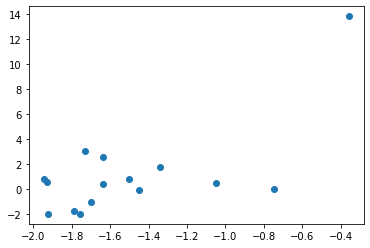

In [30]:
plot_soft6_vs_4dm4('RC')

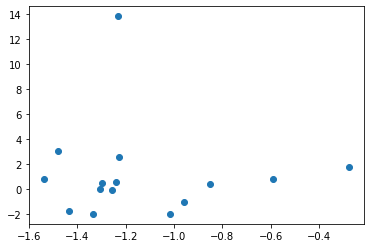

In [31]:
plot_soft6_vs_4dm4('HB')

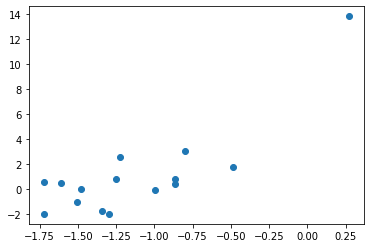

In [32]:
plot_soft6_vs_4dm4('LN')

In [33]:
soft6_model._linearETIRegression.coef_

array([ 0.66347404, -0.        ,  1.26721913])

In [34]:
soft6_model._linearETIRegression.intercept_

3.5668363238337166

In [35]:
soft6_etis = soft6_etis.rename(mapper={0: 'avg'}, axis=1)
soft6_etis['source'] = 'soft6'

In [36]:
_4dm4_eti = eti_cats[['avg']]
_4dm4_eti['source'] = '4dm4'

In [37]:
eti = pd.concat((soft6_etis, _4dm4_eti)).reset_index().groupby('index').max()

In [38]:
eti

,avg,source
index,,
--Pavin--,6.369292,4dm4
-Aishiteru-,16.792270,soft6
-Einar-,0.932870,soft6
-Guille,-1.914459,4dm4
-Julio,-0.983972,4dm4
...,...,...
u8_sunflower,-1.681280,4dm4
username1947,0.885702,4dm4
walmart5193,1.596166,soft6


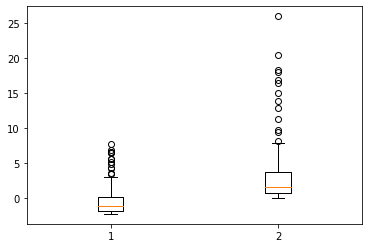

In [39]:
plt.boxplot([eti[eti['source'] == '4dm4']['avg'], eti[eti['source'] == 'soft6']['avg']])
plt.show()

In [40]:
eti['is_et'] = eti['source'].apply(lambda x: int(x == 'soft6'))

In [41]:
eti

,avg,source,is_et
index,,,
--Pavin--,6.369292,4dm4,0
-Aishiteru-,16.792270,soft6,1
-Einar-,0.932870,soft6,1
-Guille,-1.914459,4dm4,0
-Julio,-0.983972,4dm4,0
...,...,...,...
u8_sunflower,-1.681280,4dm4,0
username1947,0.885702,4dm4,0
walmart5193,1.596166,soft6,1


In [42]:
from sklearn.linear_model import LogisticRegression

x = eti['avg'].values.reshape(-1, 1)
y = eti['is_et'].values

In [43]:
et_model = LogisticRegression()

In [44]:
et_model.fit(x, y)

LogisticRegression()

In [45]:
is_et = et_model.predict_proba(x)

eti['model_prediction'] = is_et[:, -1]

In [46]:
_4dm4_et = eti.loc[_4dm4_players].sort_values('model_prediction', ascending=False)[['avg', 'model_prediction']]

In [47]:
_4dm4_et.head(15)

,avg,model_prediction
index,,
shokoha,13.858188,0.999208
Gray Hardrock,7.679832,0.972046
henryalexbr,6.792923,0.954054
Keskidi,6.506931,0.946191
MisteurFR,6.494432,0.945819
--Pavin--,6.369292,0.941968
[LS]Byte,5.556689,0.910077
Lazereed,5.500929,0.907389
RaGe Radical,5.089728,0.885250


In [48]:
et_model.coef_

array([[0.58134647]])

In [49]:
et_model.intercept_

array([-0.9157845])

In [50]:
strong_skillban_boundary = 0.9
log_strong_skillban_odds = np.log(strong_skillban_boundary / (1 - strong_skillban_boundary))
weak_skillban_boundary = 0.75
log_weak_skillban_odds = np.log(weak_skillban_boundary / (1 - weak_skillban_boundary))

In [51]:
log_strong_skillban_odds, log_weak_skillban_odds

(2.1972245773362196, 1.0986122886681098)

In [52]:
coef = float(et_model.coef_)
intercept = float(et_model.intercept_)

In [53]:
strong_eti = (log_strong_skillban_odds - intercept) / coef
weak_eti = (log_weak_skillban_odds - intercept) / coef

In [54]:
weak_eti, strong_eti

(3.4650537816307816, 5.35482578968731)

In [55]:
skillban = _4dm4_et[_4dm4_et['model_prediction'] > 0.75]
skillban['skillban_type'] = skillban['model_prediction'].apply(lambda x: "Strong Skillban" if x > 0.9 else "Weak Skillban")

In [56]:
skillban.to_csv('skillbans_4dm_soft6_list.csv')

In [57]:
skillban

,avg,model_prediction,skillban_type
index,,,
shokoha,13.858188,0.999208,Strong Skillban
Gray Hardrock,7.679832,0.972046,Strong Skillban
henryalexbr,6.792923,0.954054,Strong Skillban
Keskidi,6.506931,0.946191,Strong Skillban
MisteurFR,6.494432,0.945819,Strong Skillban
--Pavin--,6.369292,0.941968,Strong Skillban
[LS]Byte,5.556689,0.910077,Strong Skillban
Lazereed,5.500929,0.907389,Strong Skillban
RaGe Radical,5.089728,0.885250,Weak Skillban


In [58]:
skillbanned_players = skillban.index

In [59]:
from utils.highlights import get_highlighted_scores

In [61]:
shokoha_highlighted_scores = get_highlighted_scores('shokoha', _4dm4_dataset, 5)

In [65]:
_4dm4_dataset[(_4dm4_dataset['player_name'] == 'shokoha') & (_4dm4_dataset['beatmap'] == shokoha_highlighted_scores[0])][['beatmap', 'score']]

,beatmap,score
2308,SF_RC_5,993596


In [67]:
highlighted_scores = pd.DataFrame(columns=['player_name', 'beatmap', 'score'])
n_highlighted_scores = 5

In [69]:
for player in skillbanned_players:
    highlighted_player_score = get_highlighted_scores(player, _4dm4_dataset, n_highlighted_scores)
    for beatmap in highlighted_player_score:
        highlight_scr = _4dm4_dataset[(_4dm4_dataset['player_name'] == player) & (_4dm4_dataset['beatmap'] == beatmap)][['player_name', 'beatmap', 'score']]
        highlighted_scores = pd.concat((highlighted_scores, highlight_scr))

In [70]:
highlighted_scores

,player_name,beatmap,score
2308,shokoha,SF_RC_5,993596
2587,shokoha,F_HB_2,993893
2219,shokoha,SF_RC_1,995673
2574,shokoha,F_HB_1,992841
2653,shokoha,F_LN_3,990648
...,...,...,...
2065,Maykee kee,QF_LN_2,991941
2316,Maykee kee,SF_RC_6,981173
2576,Maykee kee,F_HB_2,985878
950,Maykee kee,RO32_LN_3,994739


In [71]:
highlighted_scores.to_csv('highlighted_scores.csv')